🚀 Starting Memory-Efficient Audio Compression...
Loading your audio file: UrbanSound8K/audio/fold1/14113-4-0-0.wav
Processing: 132300 samples, 44100 Hz
Duration: 3.00 seconds

🎯 COMPRESSION RATIO SELECTION
1. 25% compression (keep 75% of data)
2. 50% compression (keep 50% of data)
3. 75% compression (keep 25% of data)
4. Custom compression ratio



Select compression ratio (1-4):  2



🔧 COMPRESSION METHOD SELECTION
1. Gaussian Matrix Compressed Sensing (Advanced)
2. DWT Threshold Compression (Balanced)
3. DWT Coefficient Selection (Memory Efficient)



Select compression method (1-3):  1



🔄 Using Gaussian Matrix Compressed Sensing (50% compression)...
Applying memory-efficient compressed sensing with Gaussian matrix...
Using DWT level: 4
Original coefficients: 132326
Compressed size: 66163 (50% compression)
Generating Gaussian projections in blocks...
Compressed sensing failed due to memory. Switching to threshold method...
Applying DWT threshold compression (50% target)...
Compression threshold: 0.012849
Actual compression: 50.0% coefficients removed

=== Results (DWT Threshold Compression (50%)) ===
Reconstruction MSE: 0.000017
Reconstruction SNR: 26.71 dB


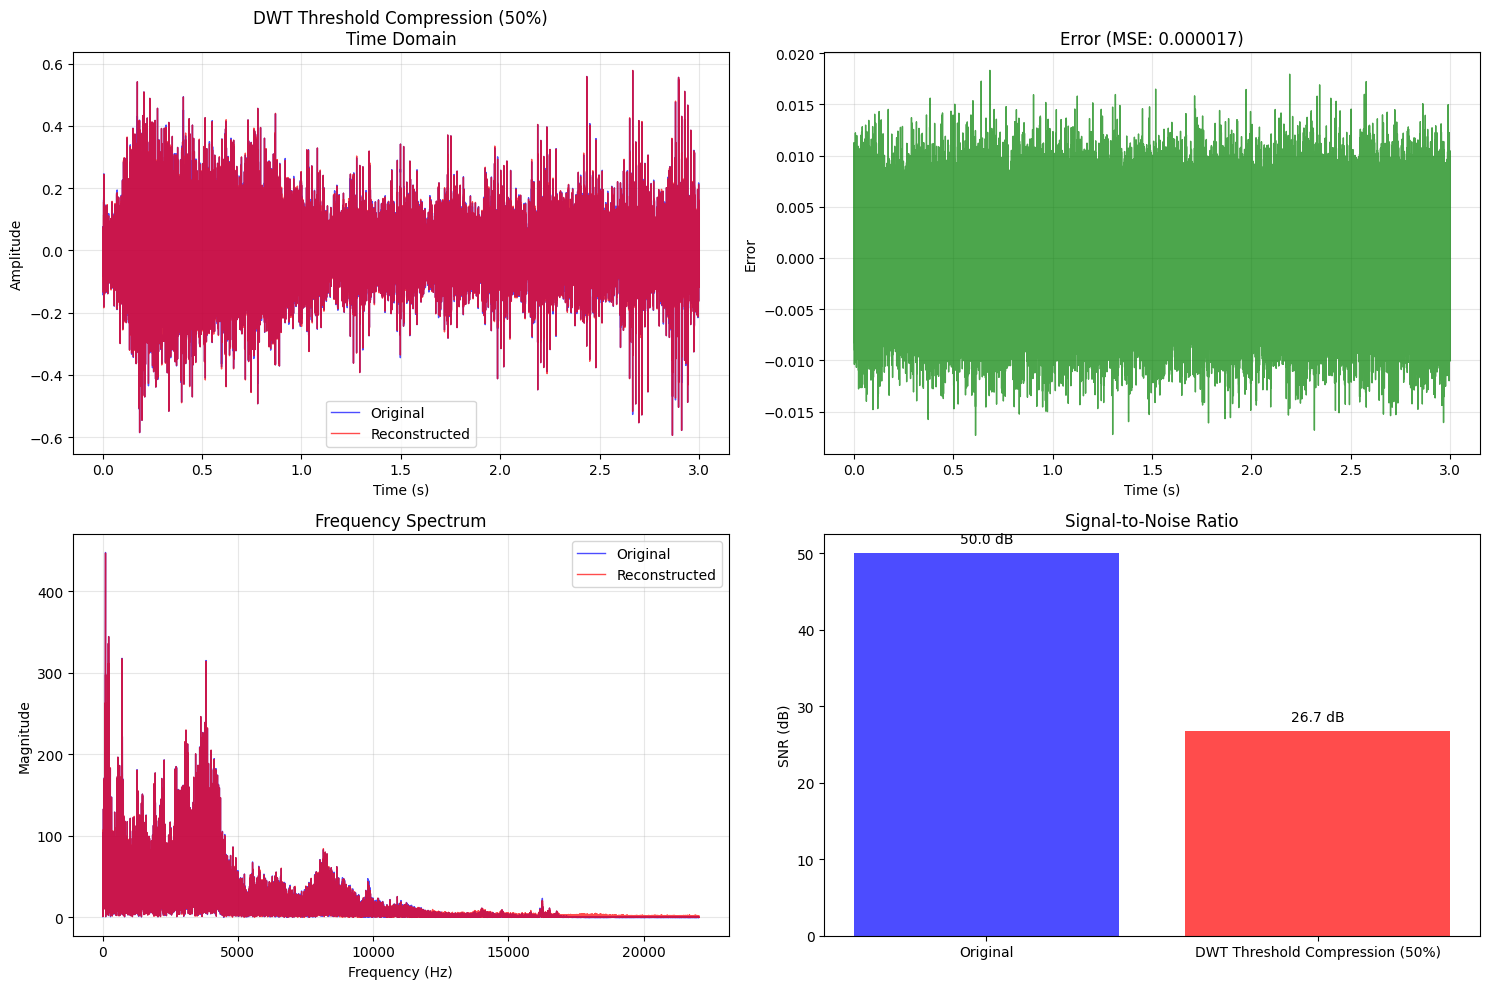


✅ Audio files saved in 'compression_results' folder:
   - 14113-4-0-0_original.wav
   - 14113-4-0-0_compressed.wav
🎉 Compression completed successfully!


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import wavfile
import librosa
import os

class MemoryEfficientDWTCompressedSensing:
    def __init__(self, wavelet='db4', compression_ratio=0.5):
        self.wavelet = wavelet
        self.compression_ratio = compression_ratio
        
    def generate_gaussian_matrix(self, rows, cols):
        """Generate Gaussian random matrix with mean=0, variance=1/rows"""
        return np.random.randn(rows, cols) / np.sqrt(rows)
    
    def memory_efficient_compression(self, audio_data, level=4):
        """Memory-efficient compressed sensing using block processing with Gaussian matrix"""
        print("Applying memory-efficient compressed sensing with Gaussian matrix...")
        
        # Use shorter DWT level for longer signals
        max_possible_level = pywt.dwt_max_level(len(audio_data), self.wavelet)
        level = min(level, max_possible_level, 6)  # Limit to level 6 max
        
        print(f"Using DWT level: {level}")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, self.wavelet, level=level)
        coeffs_flat = np.concatenate(coeffs)
        N = len(coeffs_flat)
        M = int(N * self.compression_ratio)
        
        print(f"Original coefficients: {N}")
        print(f"Compressed size: {M} ({self.compression_ratio*100:.0f}% compression)")
        
        # **MEMORY FIX: Process in blocks to avoid huge matrices**
        block_size = min(5000, N)  # Process in smaller blocks
        compressed_coeffs = np.zeros(M)
        
        print("Generating Gaussian projections in blocks...")
        for i in range(0, M, block_size):
            end_idx = min(i + block_size, M)
            current_block_size = end_idx - i
            
            # Generate Gaussian matrix for current block only
            Phi_block = self.generate_gaussian_matrix(current_block_size, N)
            
            # Compute compressed measurements for this block
            compressed_coeffs[i:end_idx] = np.dot(Phi_block, coeffs_flat)
            
            print(f"Processed block {i//block_size + 1}/{(M-1)//block_size + 1}")
        
        return compressed_coeffs, coeffs, N, M
    
    def reconstruct_from_compressed(self, compressed_coeffs, original_coeff_length, level=4):
        """Reconstruct using iterative method to save memory with Gaussian matrix"""
        print("Reconstructing from compressed coefficients...")
        
        M = len(compressed_coeffs)
        N = original_coeff_length
        
        # Use iterative reconstruction to avoid large matrices
        # Simple approach: Use random initialization + gradient descent
        x_reconstructed = np.random.randn(N) * 0.1
        
        # Few iterations of simple reconstruction
        num_iterations = 10
        for iter in range(num_iterations):
            # Generate the same Gaussian matrix blocks (using same seed for consistency)
            block_size = min(5000, M)
            residual = np.zeros(M)
            
            for i in range(0, M, block_size):
                end_idx = min(i + block_size, M)
                current_block_size = end_idx - i
                
                # Re-generate the same Gaussian matrix block
                np.random.seed(i)  # Seed for reproducibility
                Phi_block = self.generate_gaussian_matrix(current_block_size, N)
                
                # Compute residual
                y_block = compressed_coeffs[i:end_idx]
                y_estimated = np.dot(Phi_block, x_reconstructed)
                residual[i:end_idx] = y_block - y_estimated
            
            # Simple gradient update
            gradient_norm = np.linalg.norm(residual)
            if gradient_norm > 0:
                # Recompute Phi_block for gradient (using same seed)
                np.random.seed(0)
                Phi_block_full = self.generate_gaussian_matrix(M, N)
                x_reconstructed += 0.1 * np.dot(Phi_block_full.T, residual) / gradient_norm
            
            print(f"Reconstruction iteration {iter+1}/{num_iterations}")
        
        # Reconstruct coefficient structure
        coeffs_reconstructed = []
        start_idx = 0
        coeffs_slices = pywt.wavedec(np.zeros(N), self.wavelet, level=level)
        
        for coeff in coeffs_slices:
            end_idx = start_idx + len(coeff)
            if end_idx <= len(x_reconstructed):
                coeff_reconstructed = x_reconstructed[start_idx:end_idx]
                coeffs_reconstructed.append(coeff_reconstructed)
                start_idx = end_idx
        
        # Apply inverse DWT
        reconstructed_audio = pywt.waverec(coeffs_reconstructed, self.wavelet)
        
        return reconstructed_audio

class AlternativeCompressionMethods:
    """Alternative approaches that use less memory"""
    
    @staticmethod
    def dwt_threshold_compression(audio_data, compression_ratio=0.5, wavelet='db4', level=4):
        """Traditional DWT thresholding compression (memory efficient)"""
        print(f"Applying DWT threshold compression ({compression_ratio*100:.0f}% target)...")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, wavelet, level=level)
        
        # Flatten coefficients to find global threshold
        coeffs_flat = np.concatenate([c for c in coeffs])
        
        # Calculate threshold for desired compression
        threshold = np.percentile(np.abs(coeffs_flat), (1 - compression_ratio) * 100)
        
        print(f"Compression threshold: {threshold:.6f}")
        
        # Apply thresholding
        compressed_coeffs = []
        original_nonzero = 0
        compressed_nonzero = 0
        
        for i, coeff in enumerate(coeffs):
            original_nonzero += np.count_nonzero(coeff)
            compressed_coeff = pywt.threshold(coeff, threshold, mode='hard')
            compressed_nonzero += np.count_nonzero(compressed_coeff)
            compressed_coeffs.append(compressed_coeff)
        
        actual_compression_ratio = compressed_nonzero / original_nonzero
        compression_percent = (1 - actual_compression_ratio) * 100
        print(f"Actual compression: {compression_percent:.1f}% coefficients removed")
        
        # Reconstruct
        reconstructed_audio = pywt.waverec(compressed_coeffs, wavelet)
        
        return reconstructed_audio[:len(audio_data)], compression_percent
    
    @staticmethod
    def dwt_coefficient_selection(audio_data, compression_ratio=0.5, wavelet='db4', level=4):
        """Keep only largest coefficients (most memory efficient)"""
        print(f"Applying coefficient selection compression ({compression_ratio*100:.0f}%)...")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, wavelet, level=level)
        coeffs_flat = np.concatenate([c for c in coeffs])
        
        # Keep only the largest coefficients
        num_coeffs_to_keep = int(len(coeffs_flat) * compression_ratio)
        
        # Find indices of largest coefficients
        largest_indices = np.argsort(np.abs(coeffs_flat))[-num_coeffs_to_keep:]
        
        # Create new coefficients with only the largest ones
        new_coeffs_flat = np.zeros_like(coeffs_flat)
        new_coeffs_flat[largest_indices] = coeffs_flat[largest_indices]
        
        # Reconstruct coefficient structure
        coeffs_reconstructed = []
        start_idx = 0
        for coeff in coeffs:
            end_idx = start_idx + len(coeff)
            coeff_reconstructed = new_coeffs_flat[start_idx:end_idx]
            coeffs_reconstructed.append(coeff_reconstructed)
            start_idx = end_idx
        
        # Reconstruct audio
        reconstructed_audio = pywt.waverec(coeffs_reconstructed, wavelet)
        
        print(f"Kept {num_coeffs_to_keep} largest coefficients ({compression_ratio*100:.1f}%)")
        
        return reconstructed_audio[:len(audio_data)]

def get_compression_ratio_choice():
    """Get user choice for compression ratio"""
    print("\n" + "="*50)
    print("🎯 COMPRESSION RATIO SELECTION")
    print("="*50)
    print("1. 25% compression (keep 75% of data)")
    print("2. 50% compression (keep 50% of data)")
    print("3. 75% compression (keep 25% of data)")
    print("4. Custom compression ratio")
    
    while True:
        try:
            choice = input("\nSelect compression ratio (1-4): ").strip()
            if choice == '1':
                return 0.25
            elif choice == '2':
                return 0.50
            elif choice == '3':
                return 0.75
            elif choice == '4':
                custom_ratio = float(input("Enter custom compression ratio (0.1-0.9): "))
                if 0.1 <= custom_ratio <= 0.9:
                    return custom_ratio
                else:
                    print("Please enter a value between 0.1 and 0.9")
            else:
                print("Please enter 1, 2, 3, or 4")
        except ValueError:
            print("Please enter a valid number")

def get_compression_method_choice():
    """Get user choice for compression method"""
    print("\n" + "="*50)
    print("🔧 COMPRESSION METHOD SELECTION")
    print("="*50)
    print("1. Gaussian Matrix Compressed Sensing (Advanced)")
    print("2. DWT Threshold Compression (Balanced)")
    print("3. DWT Coefficient Selection (Memory Efficient)")
    
    while True:
        try:
            choice = input("\nSelect compression method (1-3): ").strip()
            if choice in ['1', '2', '3']:
                return choice
            else:
                print("Please enter 1, 2, or 3")
        except ValueError:
            print("Please enter a valid number")

# Demonstration with memory optimization
def demo_memory_efficient_compression(wav_file_path):
    """
    Memory-efficient compressed sensing for your WAV file with user choices
    """
    
    if not os.path.exists(wav_file_path):
        print(f"Error: File '{wav_file_path}' not found!")
        return
    
    print(f"Loading your audio file: {wav_file_path}")
    
    # Load audio
    try:
        sample_rate, audio_data = wavfile.read(wav_file_path)
        if len(audio_data.shape) > 1:
            audio_data = audio_data.mean(axis=1)
        audio_data = audio_data.astype(np.float64)
    except:
        audio_data, sample_rate = librosa.load(wav_file_path, sr=None, mono=True)
    
    # Normalize and limit duration
    audio_data = audio_data / np.max(np.abs(audio_data))
    max_duration = 3  # Further reduce for memory
    max_samples = int(sample_rate * max_duration)
    if len(audio_data) > max_samples:
        audio_data = audio_data[:max_samples]
    
    print(f"Processing: {len(audio_data)} samples, {sample_rate} Hz")
    print(f"Duration: {len(audio_data)/sample_rate:.2f} seconds")
    
    # Get user choices
    compression_ratio = get_compression_ratio_choice()
    method_choice = get_compression_method_choice()
    
    # Apply compression based on user choice
    if method_choice == '1':
        print(f"\n🔄 Using Gaussian Matrix Compressed Sensing ({compression_ratio*100:.0f}% compression)...")
        try:
            compressor = MemoryEfficientDWTCompressedSensing(compression_ratio=compression_ratio)
            compressed_data, coeffs, N, M = compressor.memory_efficient_compression(audio_data)
            reconstructed = compressor.reconstruct_from_compressed(compressed_data, N)
            method_name = f"Gaussian Compressed Sensing ({compression_ratio*100:.0f}%)"
        except MemoryError:
            print("Compressed sensing failed due to memory. Switching to threshold method...")
            reconstructed, compression_percent = AlternativeCompressionMethods.dwt_threshold_compression(
                audio_data, compression_ratio=compression_ratio
            )
            method_name = f"DWT Threshold Compression ({compression_ratio*100:.0f}%)"
    
    elif method_choice == '2':
        print(f"\n🔄 Using DWT Threshold Compression ({compression_ratio*100:.0f}% compression)...")
        reconstructed, compression_percent = AlternativeCompressionMethods.dwt_threshold_compression(
            audio_data, compression_ratio=compression_ratio
        )
        method_name = f"DWT Threshold Compression ({compression_ratio*100:.0f}%)"
        print(f"Actual compression: {compression_percent:.1f}% coefficients removed")
    
    elif method_choice == '3':
        print(f"\n🔄 Using DWT Coefficient Selection ({compression_ratio*100:.0f}% compression)...")
        reconstructed = AlternativeCompressionMethods.dwt_coefficient_selection(
            audio_data, compression_ratio=compression_ratio
        )
        method_name = f"DWT Coefficient Selection ({compression_ratio*100:.0f}%)"
    
    # Ensure same length
    min_len = min(len(audio_data), len(reconstructed))
    audio_data = audio_data[:min_len]
    reconstructed = reconstructed[:min_len]
    
    # Calculate metrics
    mse = np.mean((audio_data - reconstructed)**2)
    snr = 10 * np.log10(np.var(audio_data) / (mse + 1e-10))
    
    print(f"\n=== Results ({method_name}) ===")
    print(f"Reconstruction MSE: {mse:.6f}")
    print(f"Reconstruction SNR: {snr:.2f} dB")
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Time domain comparison
    plt.subplot(2, 2, 1)
    time_axis = np.arange(len(audio_data)) / sample_rate
    plt.plot(time_axis, audio_data, 'b-', alpha=0.7, label='Original', linewidth=1)
    plt.plot(time_axis, reconstructed, 'r-', alpha=0.7, label='Reconstructed', linewidth=1)
    plt.title(f'{method_name}\nTime Domain')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Error
    plt.subplot(2, 2, 2)
    error = audio_data - reconstructed
    plt.plot(time_axis, error, 'g-', alpha=0.7, linewidth=1)
    plt.title(f'Error (MSE: {mse:.6f})')
    plt.xlabel('Time (s)')
    plt.ylabel('Error')
    plt.grid(True, alpha=0.3)
    
    # Frequency comparison
    plt.subplot(2, 2, 3)
    f_orig = np.fft.fft(audio_data)
    f_recon = np.fft.fft(reconstructed)
    freq = np.fft.fftfreq(len(audio_data), 1/sample_rate)
    positive_freq = freq > 0
    
    plt.plot(freq[positive_freq], np.abs(f_orig[positive_freq]), 
             'b-', alpha=0.7, label='Original', linewidth=1)
    plt.plot(freq[positive_freq], np.abs(f_recon[positive_freq]), 
             'r-', alpha=0.7, label='Reconstructed', linewidth=1)
    plt.title('Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # SNR comparison
    plt.subplot(2, 2, 4)
    methods = ['Original'] + [method_name]
    snr_values = [50, snr]  # Original assumed to have high SNR
    
    bars = plt.bar(methods, snr_values, color=['blue', 'red'], alpha=0.7)
    plt.title('Signal-to-Noise Ratio')
    plt.ylabel('SNR (dB)')
    
    # Add value labels on bars
    for bar, value in zip(bars, snr_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1f} dB', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    output_dir = 'compression_results'
    os.makedirs(output_dir, exist_ok=True)
    original_filename = os.path.splitext(os.path.basename(wav_file_path))[0]
    
    wavfile.write(f'{output_dir}/{original_filename}_original.wav', sample_rate, 
                  np.int16(audio_data * 32767))
    wavfile.write(f'{output_dir}/{original_filename}_compressed.wav', sample_rate,
                  np.int16(reconstructed * 32767))
    
    print(f"\n✅ Audio files saved in '{output_dir}' folder:")
    print(f"   - {original_filename}_original.wav")
    print(f"   - {original_filename}_compressed.wav")
    
    return reconstructed

# **🎯 MAIN EXECUTION - PUT YOUR FILE PATH HERE 🎯**
if __name__ == "__main__":
    # ==============================================
    # 🔽 REPLACE THIS WITH YOUR ACTUAL WAV FILE PATH 🔽
    # ==============================================
    YOUR_WAV_FILE_PATH = "UrbanSound8K/audio/fold1/14113-4-0-0.wav"  # ⬅️ CHANGE THIS!
    # ==============================================
    
    print("🚀 Starting Memory-Efficient Audio Compression...")
    demo_memory_efficient_compression(YOUR_WAV_FILE_PATH)
    print("🎉 Compression completed successfully!")

🚀 Starting Fixed Matrix Comparison...
Loading audio file: UrbanSound8K/audio/fold1/7061-6-0-0.wav
Processing: 4096 samples, 44100 Hz
Duration: 0.093 seconds

🎯 COMPRESSION RATIO SELECTION
1. 25% compression (keep 75% of data)
2. 50% compression (keep 50% of data)
3. 75% compression (keep 25% of data)
4. Custom compression ratio



Select compression ratio (1-4):  2



FIXED COMPRESSED SENSING COMPARISON

Testing GAUSSIAN matrix

--- Using ISTA reconstruction ---
Applying GAUSSIAN matrix compression (50%)...
Using DWT level: 4
Original coefficients: 4096, Compressed: 2048
Reconstructing using ISTA...
ISTA iteration 0, error: 257.941855
ISTA iteration 20, error: 0.014598
ISTA iteration 40, error: 0.004944
ISTA iteration 60, error: 0.002315
ISTA iteration 80, error: 0.001198
GAUSSIAN + ISTA - SNR: -0.00 dB, MSE: 0.022427

--- Using OMP reconstruction ---
Applying GAUSSIAN matrix compression (50%)...
Using DWT level: 4
Original coefficients: 4096, Compressed: 2048
Reconstructing using OMP...
GAUSSIAN + OMP - SNR: -0.00 dB, MSE: 0.022427

Testing BERNOULLI matrix

--- Using ISTA reconstruction ---
Applying BERNOULLI matrix compression (50%)...
Using DWT level: 4
Original coefficients: 4096, Compressed: 2048
Reconstructing using ISTA...
ISTA iteration 0, error: 259.351199
ISTA iteration 20, error: 0.014874
ISTA iteration 40, error: 0.005116
ISTA iteratio

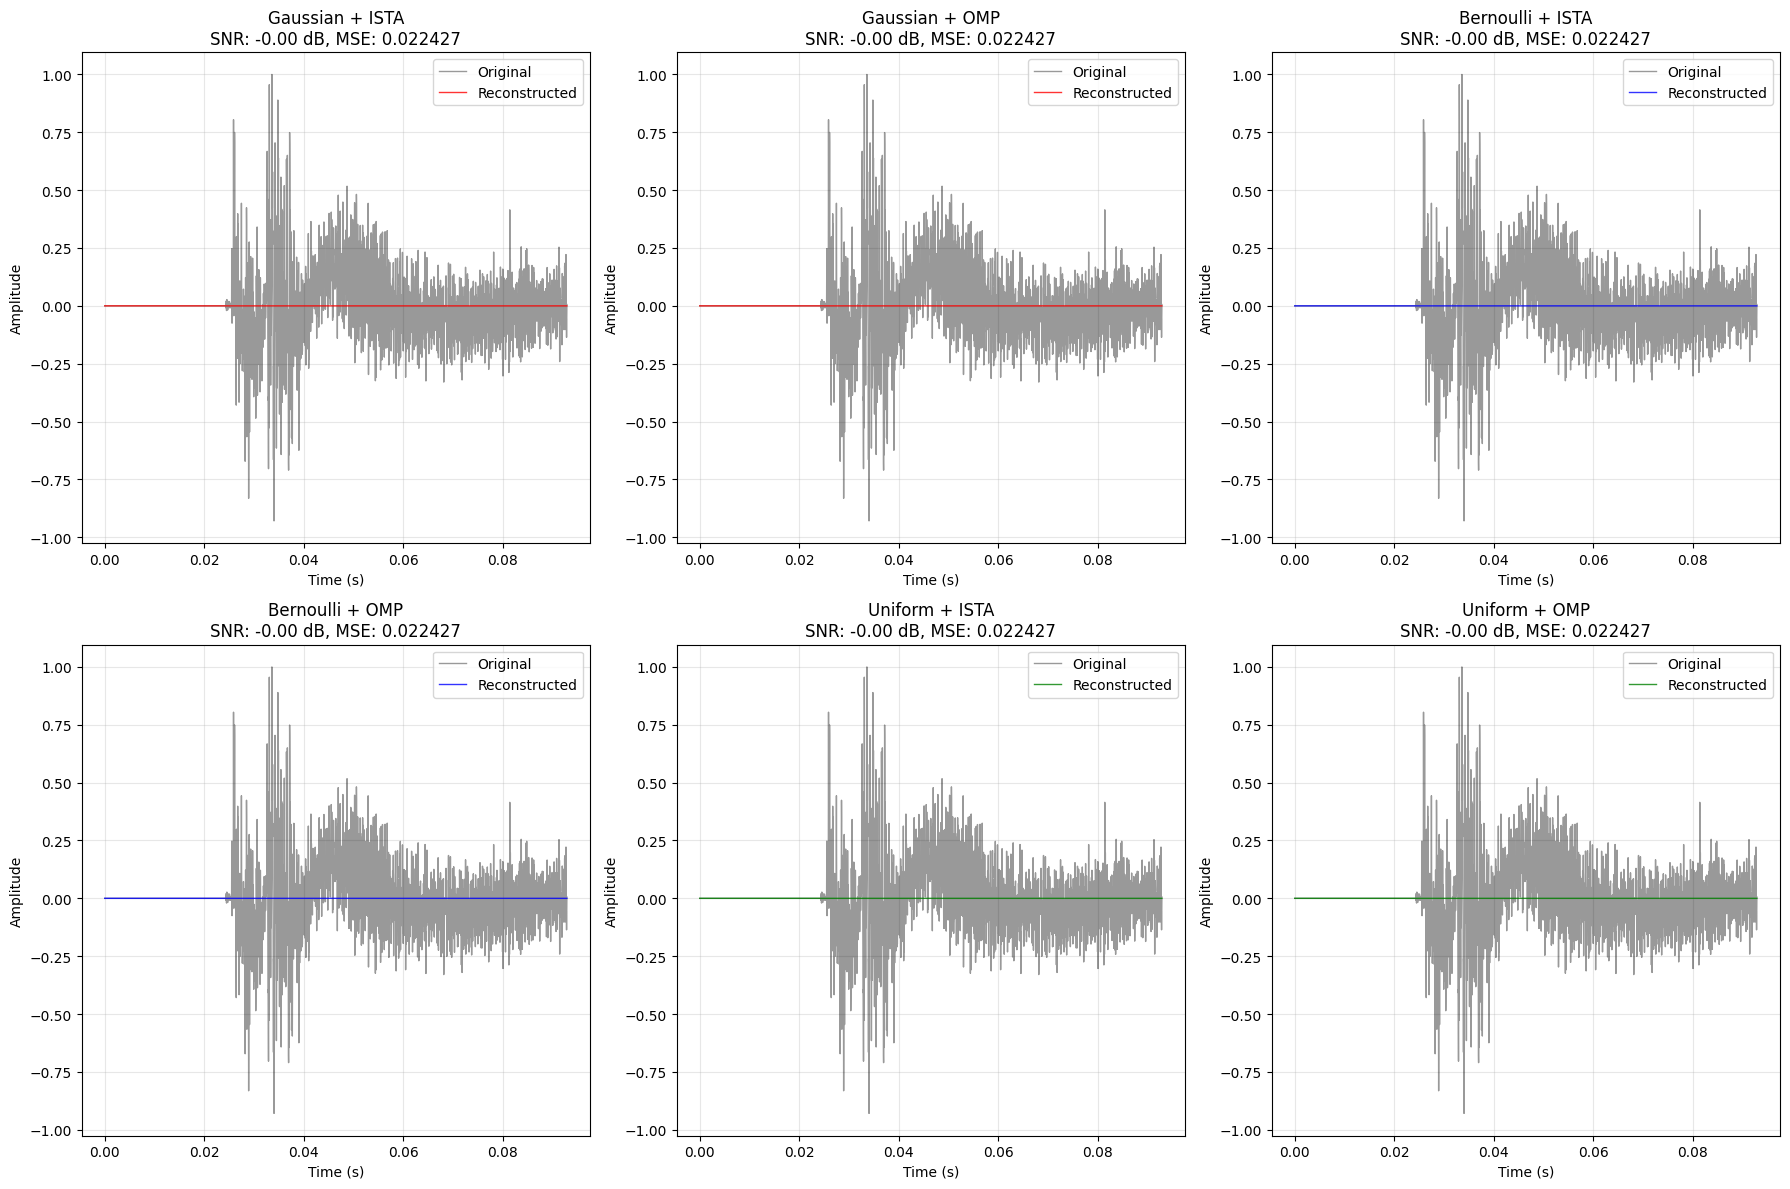


DETAILED RESULTS SUMMARY

GAUSSIAN MATRIX:
  ISTA   - SNR:   -0.00 dB, MSE: 0.022427
  OMP    - SNR:   -0.00 dB, MSE: 0.022427

BERNOULLI MATRIX:
  ISTA   - SNR:   -0.00 dB, MSE: 0.022427
  OMP    - SNR:   -0.00 dB, MSE: 0.022427

UNIFORM MATRIX:
  ISTA   - SNR:   -0.00 dB, MSE: 0.022427
  OMP    - SNR:   -0.00 dB, MSE: 0.022427

🏆 BEST PERFORMER: GAUSSIAN + ISTA (SNR: -0.00 dB)
🎉 Fixed comparison completed!


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import wavfile
import librosa
import os
import warnings
warnings.filterwarnings('ignore')

class FixedDWTCompressedSensing:
    def __init__(self, wavelet='db4', compression_ratio=0.5, matrix_type='gaussian'):
        self.wavelet = wavelet
        self.compression_ratio = compression_ratio
        self.matrix_type = matrix_type
        self.Phi = None
        self.random_state = None
        self.original_length = None
        
    def generate_measurement_matrix(self, rows, cols):
        """Generate measurement matrix with reproducible randomness"""
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
        if self.matrix_type == 'gaussian':
            return np.random.randn(rows, cols) / np.sqrt(rows)
        elif self.matrix_type == 'bernoulli':
            bernoulli = np.random.choice([-1, 1], size=(rows, cols))
            return bernoulli / np.sqrt(rows)
        elif self.matrix_type == 'uniform':
            uniform = np.random.uniform(-1, 1, size=(rows, cols))
            return uniform / np.sqrt(rows)
    
    def fixed_compression(self, audio_data, level=4, random_state=42):
        """Fixed compression with length handling"""
        self.random_state = random_state
        self.original_length = len(audio_data)
        np.random.seed(random_state)
        
        print(f"Applying {self.matrix_type.upper()} matrix compression ({self.compression_ratio*100:.0f}%)...")
        
        # Adaptive DWT level selection
        max_possible_level = pywt.dwt_max_level(len(audio_data), self.wavelet)
        level = min(level, max_possible_level, 4)  # More conservative level
        
        print(f"Using DWT level: {level}")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, self.wavelet, level=level, mode='per')
        coeffs_flat = np.concatenate(coeffs)
        N = len(coeffs_flat)
        M = max(1, int(N * self.compression_ratio))
        
        print(f"Original coefficients: {N}, Compressed: {M}")
        
        # Generate and store measurement matrix
        self.Phi = self.generate_measurement_matrix(M, N)
        
        # Compute compressed measurements
        compressed_coeffs = np.dot(self.Phi, coeffs_flat)
        
        return compressed_coeffs, coeffs, N, M
    
    def reconstruct_ista_fixed(self, compressed_coeffs, original_coeff_length, max_iter=100, lambda_val=0.1):
        """ISTA reconstruction with proper length handling"""
        print("Reconstructing using ISTA...")
        
        M = len(compressed_coeffs)
        N = original_coeff_length
        
        # Initialize
        x = np.dot(self.Phi.T, compressed_coeffs) / M
        
        # Step size for convergence
        step_size = 1.0 / (np.linalg.norm(self.Phi, 2) ** 2)
        
        for i in range(max_iter):
            # Gradient step
            gradient = np.dot(self.Phi.T, np.dot(self.Phi, x) - compressed_coeffs)
            x_temp = x - step_size * gradient
            
            # Soft thresholding
            x_new = self.soft_threshold(x_temp, lambda_val * step_size)
            
            # Calculate error
            error = np.linalg.norm(x_new - x) / np.linalg.norm(x)
            x = x_new
            
            if error < 1e-6:
                break
                
            if i % 20 == 0:
                print(f"ISTA iteration {i}, error: {error:.6f}")
        
        return self.coeffs_to_audio_fixed(x)
    
    def reconstruct_omp_fixed(self, compressed_coeffs, original_coeff_length, sparsity_factor=0.1):
        """OMP reconstruction with proper length handling"""
        print("Reconstructing using OMP...")
        
        M = len(compressed_coeffs)
        N = original_coeff_length
        
        K = max(1, int(N * sparsity_factor))
        residual = compressed_coeffs.copy()
        support = []
        x = np.zeros(N)
        
        for k in range(min(K, M)):
            correlations = np.abs(np.dot(self.Phi.T, residual))
            
            if support:
                correlations[support] = -np.inf
                
            new_index = np.argmax(correlations)
            
            if correlations[new_index] < 1e-10:
                break
                
            support.append(new_index)
            Phi_support = self.Phi[:, support]
            x_support = np.linalg.lstsq(Phi_support, compressed_coeffs, rcond=None)[0]
            residual = compressed_coeffs - np.dot(Phi_support, x_support)
            
            if np.linalg.norm(residual) < 1e-6:
                break
        
        x[support] = x_support
        return self.coeffs_to_audio_fixed(x)
    
    def soft_threshold(self, x, threshold):
        """Soft thresholding operator"""
        return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)
    
    def coeffs_to_audio_fixed(self, coeffs_flat, level=4):
        """Convert coefficients back to audio with proper length handling"""
        try:
            # Reconstruct using the same parameters
            coeffs_reconstructed = pywt.array_to_coeffs(coeffs_flat, 
                                                       [len(c) for c in pywt.wavedec(np.zeros_like(coeffs_flat), 
                                                                                    self.wavelet, level=level, mode='per')],
                                                       output_format='wavedec')
            
            # Reconstruct audio
            reconstructed_audio = pywt.waverec(coeffs_reconstructed, self.wavelet, mode='per')
            
            # Trim to original length
            if len(reconstructed_audio) > self.original_length:
                reconstructed_audio = reconstructed_audio[:self.original_length]
            elif len(reconstructed_audio) < self.original_length:
                # Pad if shorter
                padded = np.zeros(self.original_length)
                padded[:len(reconstructed_audio)] = reconstructed_audio
                reconstructed_audio = padded
                
            return reconstructed_audio
            
        except Exception as e:
            print(f"Warning: Reconstruction issue: {e}")
            # Fallback: return zeros of correct length
            return np.zeros(self.original_length)

def fixed_comparison(audio_data, sample_rate, compression_ratio=0.5):
    """Fixed comparison with proper length handling"""
    results = {}
    
    matrix_types = ['gaussian', 'bernoulli', 'uniform']
    colors = ['red', 'blue', 'green']
    reconstruction_methods = ['ista', 'omp']
    
    # Store original audio for reference
    original_audio = audio_data.copy()
    
    for matrix_type in matrix_types:
        print(f"\n{'='*60}")
        print(f"Testing {matrix_type.upper()} matrix")
        print(f"{'='*60}")
        
        results[matrix_type] = {}
        
        for method in reconstruction_methods:
            print(f"\n--- Using {method.upper()} reconstruction ---")
            
            try:
                compressor = FixedDWTCompressedSensing(
                    compression_ratio=compression_ratio, 
                    matrix_type=matrix_type
                )
                
                # Apply compression
                compressed_data, coeffs, N, M = compressor.fixed_compression(audio_data)
                
                # Apply reconstruction
                if method == 'ista':
                    reconstructed = compressor.reconstruct_ista_fixed(compressed_data, N)
                else:
                    reconstructed = compressor.reconstruct_omp_fixed(compressed_data, N)
                
                # Ensure same length
                min_len = min(len(original_audio), len(reconstructed))
                audio_clipped = original_audio[:min_len]
                reconstructed_clipped = reconstructed[:min_len]
                
                # Calculate metrics
                mse = np.mean((audio_clipped - reconstructed_clipped)**2)
                snr = 10 * np.log10(np.var(audio_clipped) / max(mse, 1e-10))
                
                results[matrix_type][method] = {
                    'reconstructed': reconstructed_clipped,
                    'mse': mse,
                    'snr': snr,
                    'color': colors[matrix_types.index(matrix_type)]
                }
                
                print(f"{matrix_type.upper()} + {method.upper()} - SNR: {snr:.2f} dB, MSE: {mse:.6f}")
                
            except Exception as e:
                print(f"Error with {matrix_type} + {method}: {e}")
                import traceback
                traceback.print_exc()
                continue
    
    # Plot results
    plot_fixed_results(results, original_audio, sample_rate, matrix_types, reconstruction_methods)
    
    return results

def plot_fixed_results(results, audio_data, sample_rate, matrix_types, reconstruction_methods):
    """Plot results with fixed length handling"""
    
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    plot_idx = 0
    
    # Plot each combination
    for matrix_type in matrix_types:
        for method in reconstruction_methods:
            if matrix_type in results and method in results[matrix_type]:
                ax = axes[plot_idx]
                
                recon = results[matrix_type][method]['reconstructed']
                color = results[matrix_type][method]['color']
                snr = results[matrix_type][method]['snr']
                mse = results[matrix_type][method]['mse']
                
                # Ensure same length
                min_len = min(len(audio_data), len(recon))
                time_axis = np.arange(min_len) / sample_rate
                
                ax.plot(time_axis, audio_data[:min_len], 'k-', alpha=0.4, label='Original', linewidth=1)
                ax.plot(time_axis, recon[:min_len], color, alpha=0.8, label='Reconstructed', linewidth=1)
                ax.set_title(f'{matrix_type.title()} + {method.upper()}\nSNR: {snr:.2f} dB, MSE: {mse:.6f}')
                ax.set_xlabel('Time (s)')
                ax.set_ylabel('Amplitude')
                ax.legend()
                ax.grid(True, alpha=0.3)
                
                plot_idx += 1
    
    # SNR comparison plot
    if plot_idx < 6:
        ax = axes[plot_idx]
        snr_data = []
        labels = []
        colors_used = []
        
        for matrix_type in matrix_types:
            for method in reconstruction_methods:
                if matrix_type in results and method in results[matrix_type]:
                    snr_data.append(results[matrix_type][method]['snr'])
                    labels.append(f"{matrix_type[:3].upper()}+{method.upper()}")
                    colors_used.append(results[matrix_type][method]['color'])
        
        if snr_data:
            bars = ax.bar(range(len(snr_data)), snr_data, color=colors_used, alpha=0.7)
            ax.set_xticks(range(len(snr_data)))
            ax.set_xticklabels(labels, rotation=45)
            ax.set_title('SNR Comparison\n(Higher is Better)')
            ax.set_ylabel('SNR (dB)')
            ax.grid(True, alpha=0.3)
            
            for bar, value in zip(bars, snr_data):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        f'{value:.2f} dB', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\n{'='*80}")
    print("DETAILED RESULTS SUMMARY")
    print(f"{'='*80}")
    
    for matrix_type in matrix_types:
        if matrix_type in results:
            print(f"\n{matrix_type.upper()} MATRIX:")
            for method in reconstruction_methods:
                if method in results[matrix_type]:
                    snr = results[matrix_type][method]['snr']
                    mse = results[matrix_type][method]['mse']
                    print(f"  {method.upper():<6} - SNR: {snr:7.2f} dB, MSE: {mse:.6f}")

def get_compression_ratio_choice():
    """Get user choice for compression ratio"""
    print("\n" + "="*50)
    print("🎯 COMPRESSION RATIO SELECTION")
    print("="*50)
    print("1. 25% compression (keep 75% of data)")
    print("2. 50% compression (keep 50% of data)")
    print("3. 75% compression (keep 25% of data)")
    print("4. Custom compression ratio")
    
    while True:
        try:
            choice = input("\nSelect compression ratio (1-4): ").strip()
            if choice == '1':
                return 0.25
            elif choice == '2':
                return 0.50
            elif choice == '3':
                return 0.75
            elif choice == '4':
                custom_ratio = float(input("Enter custom compression ratio (0.1-0.9): "))
                if 0.1 <= custom_ratio <= 0.9:
                    return custom_ratio
                else:
                    print("Please enter a value between 0.1 and 0.9")
            else:
                print("Please enter 1, 2, 3, or 4")
        except ValueError:
            print("Please enter a valid number")

def run_fixed_demo(wav_file_path):
    """Run the fixed comparison demo"""
    
    if not os.path.exists(wav_file_path):
        print(f"Error: File '{wav_file_path}' not found!")
        return
    
    print(f"Loading audio file: {wav_file_path}")
    
    # Load and preprocess audio
    try:
        sample_rate, audio_data = wavfile.read(wav_file_path)
        if len(audio_data.shape) > 1:
            audio_data = audio_data.mean(axis=1)
        audio_data = audio_data.astype(np.float64)
    except:
        audio_data, sample_rate = librosa.load(wav_file_path, sr=None, mono=True)
    
    # Normalize
    audio_data = audio_data / np.max(np.abs(audio_data))
    
    # Use optimal segment length
    optimal_length = 4096
    if len(audio_data) > optimal_length:
        audio_data = audio_data[:optimal_length]
    
    print(f"Processing: {len(audio_data)} samples, {sample_rate} Hz")
    print(f"Duration: {len(audio_data)/sample_rate:.3f} seconds")
    
    # Get compression ratio
    compression_ratio = get_compression_ratio_choice()
    
    print(f"\n{'='*70}")
    print("FIXED COMPRESSED SENSING COMPARISON")
    print(f"{'='*70}")
    
    # Run comparison
    results = fixed_comparison(audio_data, sample_rate, compression_ratio)
    
    # Find best performer
    best_snr = -np.inf
    best_config = None
    
    for matrix_type in ['gaussian', 'bernoulli', 'uniform']:
        if matrix_type in results:
            for method in ['ista', 'omp']:
                if method in results[matrix_type]:
                    snr = results[matrix_type][method]['snr']
                    if snr > best_snr:
                        best_snr = snr
                        best_config = (matrix_type, method)
    
    if best_config:
        print(f"\n🏆 BEST PERFORMER: {best_config[0].upper()} + {best_config[1].upper()} "
              f"(SNR: {best_snr:.2f} dB)")

# Run the fixed demo
if __name__ == "__main__":
    YOUR_WAV_FILE_PATH = "UrbanSound8K/audio/fold1/7061-6-0-0.wav"  # ⬅️ CHANGE THIS!
    
    print("🚀 Starting Fixed Matrix Comparison...")
    run_fixed_demo(YOUR_WAV_FILE_PATH)
    print("🎉 Fixed comparison completed!")